In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from collections import defaultdict
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Objectives
In this notebook, we will be addressing subgroup B question 2.

2. What changes to attraction layouts, schedules, or operations would optimize the guest experience?
- Create an algorithm to optimize guest flow based on predicted demand and guest preferences.
- Simulate the impact of proposed changes on wait times, guest satisfaction, and revenue.

From subgroup B question 1, we have identified the key demand fluctuation factors, namely:
- Previous wait time influence: The model considers the average wait time from the previous day. If the wait time was high or low yesterday, it will have a direct effect on today’s expected wait time.
- Seasonal influence: Wait times can vary by day of the week
- Precipitation: Increased rainfall can either slightly decrease or marginally increase wait times, depending on how visitors react to weather conditions.
- Public/school holidays: Holidays generally lead to increased visitor numbers and longer wait times.

Since many of the factors are exogeneous, we decided to relook into our survey data to determine guest preferences.
We focused on attraction data and not food or shopping since a large proportion of the survey questions target attractions and we were unable to accurately predict demand for food and shopping outlets due to a lack of data.

In [2]:
# Load in datasets
survey_data = pd.read_csv('../data/final_synthetic_data.csv')
forecast_data = pd.read_csv('../data/collated_forecasts_per_ride.csv')

# Analysis of survey responses to boost Guest Satisfaction

To target Guest Satisfaction, we conducted the following analysis on our survey data:
1. Use correlation analysis on survey variables to determine their influence on overall guest satisfaction
2. Conduct text-analysis on open-ended questions to extract common complaints and improvement suggestions

This will provide business insights into factors affecting guest satisfaction, allowing us to suggest improvements that align with guests' expectations

In [28]:
survey_data.head()

,age,gender,occupation,visitor_profile,ticket_purchase_method,ticket_type,special_event_ticket,ticket_purchase_ease,visitor_type,what are your preferred attraction(s)? select all that apply.,...,overall_staff_service,park_cleanliness,park_seating_availability,restroom_accessibility,overall_satisfaction,which aspect of your visit was the most disappointing? (select all that apply),return_likelihood,recommendation_likelihood,additional_comments,source
0,18 - 25,Male,Student,Singaporean,"Third Party Vendor (e.g. Klook, Trip.com)",Regular ticket with Express Pass,No,4,Group,"Thrill Rides, Shows",...,4,4,Yes,4,4,"Long wait times, Overcrowded attractions",Maybe,Yes,install water cooler given singapore humid cli...,real
1,18 - 25,Female,Employed,Singaporean,Resort World Sentosa Website,One-day regular ticket,No,4,Group,"Thrill Rides, Special Events (e.g. Halloween H...",...,5,5,Yes,5,5,NaN,Yes,Yes,everything gd,real
2,18 - 25,Female,Student,Singaporean,"Third Party Vendor (e.g. Klook, Trip.com)",One-day regular ticket,No,5,Group,Thrill Rides,...,3,3,No,2,4,"Long wait times, Poor weather conditions, Over...",Yes,Yes,shorter waiting time bench shade around park b...,real
3,18 - 25,Male,Student,Singaporean,"Third Party Vendor (e.g. Klook, Trip.com)",One-day regular ticket,Yes,3,Group,"Thrill Rides, Shows",...,4,4,Yes,4,4,Long wait times,Yes,Yes,shorter waiting time,real
4,18 - 25,Male,Student,Singaporean,Resort World Sentosa Website,One-day regular ticket,No,5,Group,"Thrill Rides, Shows",...,4,4,No,4,3,"Long wait times, Overcrowded attractions",Maybe,Yes,maybe put aircon waitingqueuing area sheltered...,real


## 1. Correlation Analysis

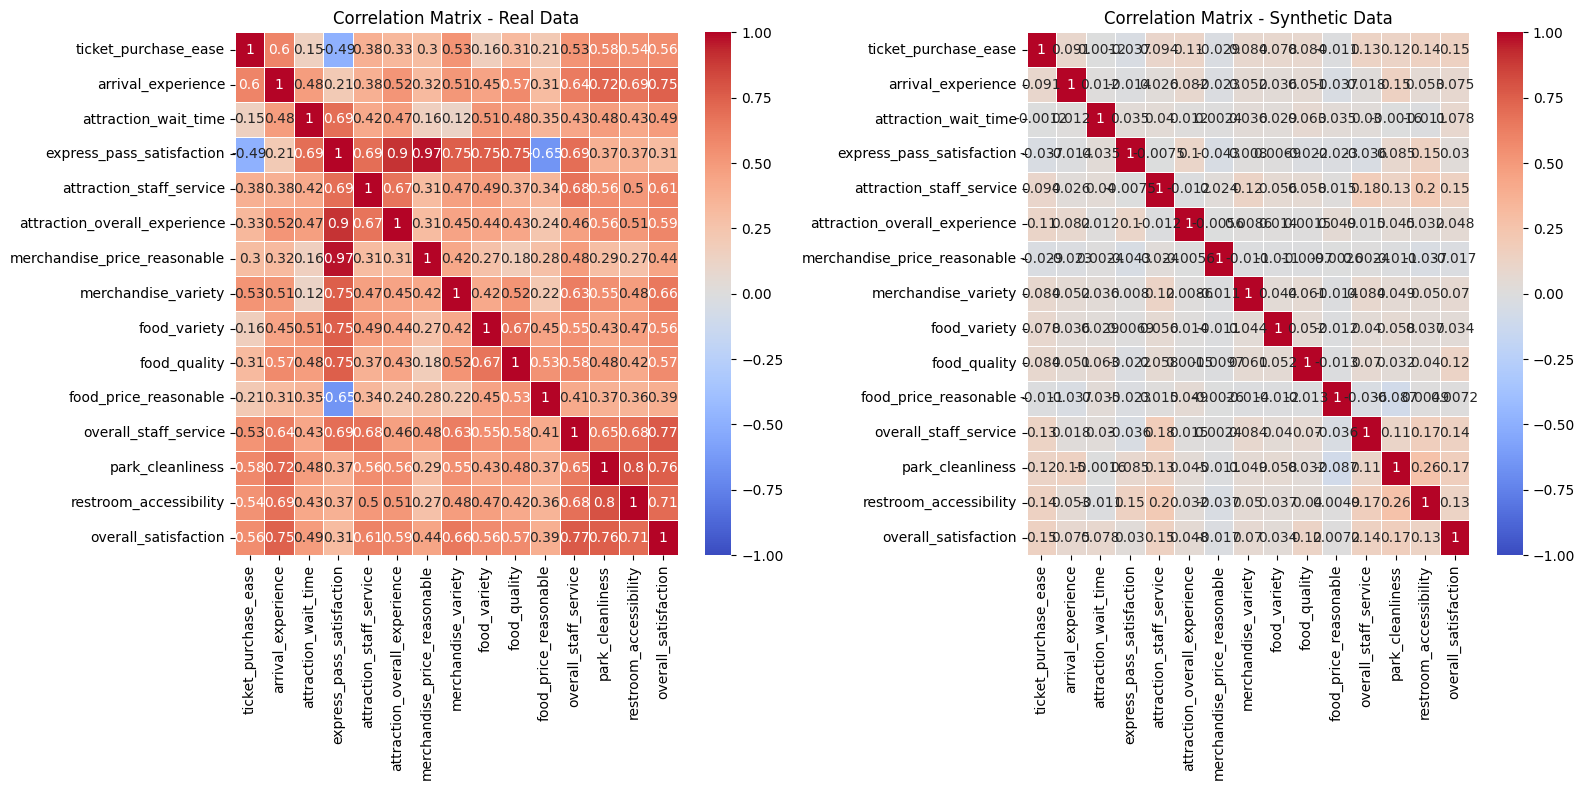

In [29]:
# Checking for correlation
selected_columns = [
    'ticket_purchase_ease', 'arrival_experience', 'attraction_wait_time', 
    'express_pass_satisfaction', 'attraction_staff_service', 'attraction_overall_experience',
    'merchandise_price_reasonable', 'merchandise_variety', 'food_variety', 
    'food_quality', 'food_price_reasonable', 'overall_staff_service', 
    'park_cleanliness', 'restroom_accessibility', 'overall_satisfaction'
]

# Split dataset into real and synthetic data
real_data = survey_data.iloc[:69][selected_columns]
synthetic_data = survey_data.iloc[69:][selected_columns]

# Calculate correlation matrices
real_corr_matrix = real_data.corr()
synthetic_corr_matrix = synthetic_data.corr()

# Set up the matplotlib figure for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot heatmap for real data correlations
sns.heatmap(real_corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5, ax=axes[0])
axes[0].set_title("Correlation Matrix - Real Data")

# Plot heatmap for synthetic data correlations
sns.heatmap(synthetic_corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5, ax=axes[1])
axes[1].set_title("Correlation Matrix - Synthetic Data")

plt.tight_layout()
plt.show()

We can see that after the generation of synthetic data, the correlations of many variables have diminished. This is likely because the original data offers limited examples of relationships, leading to a narrower scope of variability. Due to this limitation, we are not able to determine accurate correlations from the synthetic data, hence we use only real responses for our correlation analysis, focusing on variables related to attractions and guest satisfaction.

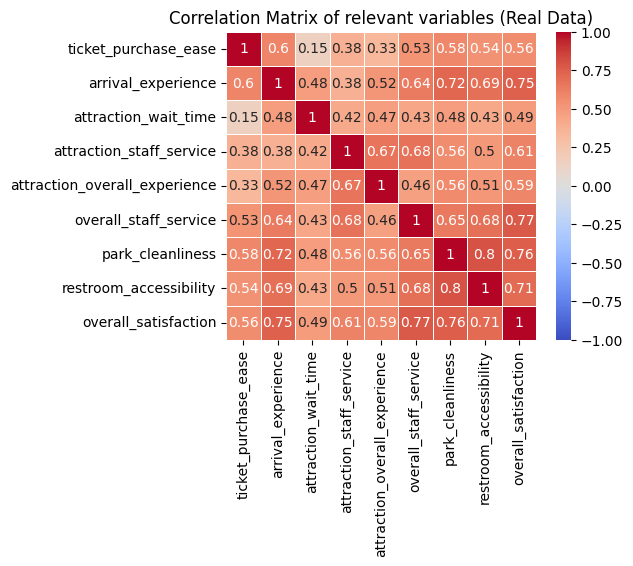

In [30]:
# Performing correlation analysis on related variables
reselected_columns = [
    'ticket_purchase_ease', 'arrival_experience', 'attraction_wait_time', 
    'attraction_staff_service', 'attraction_overall_experience',
    'overall_staff_service', 'park_cleanliness', 'restroom_accessibility', 
    'overall_satisfaction'
]

# Select only real responses due to correlation limitations
selected_real_data = survey_data.iloc[:69][reselected_columns]
corr_matrix = selected_real_data.corr()

# Plot heatmap for real data correlations
fig, ax = plt.subplots(figsize=(5, 4))

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5, ax=ax)
ax.set_title("Correlation Matrix of relevant variables (Real Data)")

plt.show()

From the correlation matrix, we can see that most variables are positively correlated with overall satisfaction. In particular, 'overall_staff_service', 'park_cleanliness', 'arrival_experience' and 'restroom_accessibility' have stronger positive correlation scores of > 0.7, while 'attraction_staff_service', 'attraction_overall_experience' and 'ticket_purchase_ease' are moderately correlated with 'overall_satisfaction', with correlation scores of > 0.55. 'attraction_wait_time' has the lowest correlation of 0.49.

In view of this, we consider the top 5 variables, 'overall_staff_service', 'park_cleanliness', 'arrival_experience', 'restroom_accessibility' and 'attraction_staff_service' for further analysis.

We proceed to use Spearman’s rank correlation for further analysis as it is well-suited for analysing monotonic relationships between ordinal variables, such as our rating scales (1-5). Using Spearman's rank correlation, we aim to examine pairwise relationships between variables and evaluate if the correlations are statistically significant


In [31]:
top_5_features = ['overall_staff_service', 'park_cleanliness', 'arrival_experience',
                  'restroom_accessibility', 'attraction_staff_service']

for feature in top_5_features:
    corr, p_value = spearmanr(selected_real_data[feature], selected_real_data['overall_satisfaction'])
    print(f"Spearman correlation between {feature} and overall_satisfaction : {corr:.4g}, p-value: {p_value:.4g}")


Spearman correlation between overall_staff_service and overall_satisfaction : 0.6827, p-value: 1.039e-10
Spearman correlation between park_cleanliness and overall_satisfaction : 0.6492, p-value: 1.604e-09
Spearman correlation between arrival_experience and overall_satisfaction : 0.6425, p-value: 2.656e-09
Spearman correlation between restroom_accessibility and overall_satisfaction : 0.5737, p-value: 2.558e-07
Spearman correlation between attraction_staff_service and overall_satisfaction : 0.5768, p-value: 2.13e-07


Analysis of results:
1. Overall Staff Service vs. Overall Satisfaction
- Correlation: 0.6827, p-value: 1.039e-10
- There is a strong positive correlation, indicating that higher ratings for overall staff service are associated with higher overall satisfaction. The p-value is extremely low, suggesting that this correlation is statistically significant.

2. Park Cleanliness vs. Overall Satisfaction
- Correlation: 0.6492, p-value: 1.604e-09
- This also shows a strong positive correlation. Higher cleanliness ratings are associated with higher satisfaction ratings. The p-value reinforces that this result is statistically significant.

3. Arrival Experience vs. Overall Satisfaction
- Correlation: 0.6425, p-value: 2.656e-09
- This indicates a strong positive relationship between arrival experience and overall satisfaction. The p-value is extremely low, hence the correlation is statistically significant.

4. Restroom Accessibility vs. Overall Satisfaction
- Correlation: 0.5737, p-value: 2.558e-07
- There is a moderate positive correlation. Improved restroom accessibility is associated with higher overall satisfaction. The p-value indicates that this correlation is also statistically significant.

5. Attraction Staff Service vs. Overall Satisfaction
- Correlation: 0.5768, p-value: 2.13e-07
- Similar to restroom accessibility, this shows a moderate positive correlation, suggesting that better attraction staff service correlates with increased satisfaction. The p-value is statistical significance.


The strongest correlation is between overall staff service and overall satisfaction, followed closely by park cleanliness and arrival experience. This indicates that improving these aspects could have a significant positive impact on guest satisfaction. All correlations are statistically significant with p-values well below threshold of 0.05. This suggests that the observed relationships are unlikely to be due to random chance, reinforcing the reliability of these correlations. Given these correlations, it would be beneficial to focus on improving staff service, cleanliness, and the arrival experience, as these factors are likely to enhance overall guest satisfaction.

## 2. Text-analysis
Next, we analyse the results of two questions from the survey that are relevant to guest preferences and experience:

1. 'what are your preferred attraction(s)? select all that apply.'
2. 'which aspect of your visit was the most disappointing? (select all that apply)'

In [32]:
# Downloading necessary packages
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('punkt_tab')

In [33]:

def analyze_select_all(data, question):
    responses = data[question].dropna().apply(str)
    
    all_options = [option.strip() for response in responses for option in response.split(',')]
    option_counts = Counter(all_options)
    print(option_counts)
    
    # Plot the word count graph
    options, counts = zip(*option_counts.most_common()) 
    plt.barh(options, counts, color='skyblue')
    plt.xlabel('Count')
    plt.ylabel("Aspects")
    plt.gca().invert_yaxis() 
    plt.grid(False)
    plt.gca().spines["top"].set_visible(False)  
    plt.gca().spines["right"].set_visible(False)  
    plt.gca().spines["left"].set_visible(False)
    plt.show()

Counter({'Thrill Rides': 4112, 'Special Events (e.g. Halloween Horror Nights)': 2686, 'Shows': 1811, 'Food and Shopping': 1535, 'Kid-friendly': 1458})


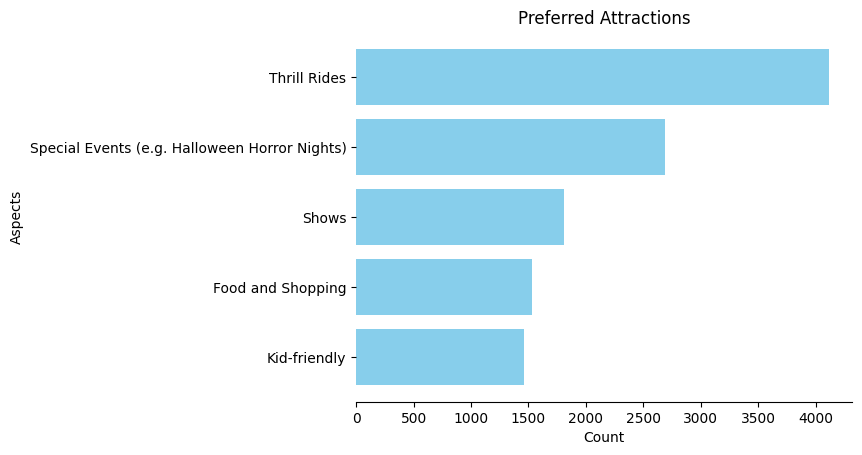

Counter({'Long wait times': 3956, 'Overcrowded attractions': 3517, 'Poor weather conditions': 1581, 'Limited dining options': 1268, 'Ride breakdowns': 633, 'Unfriendly staff': 308, 'lame rides': 86})


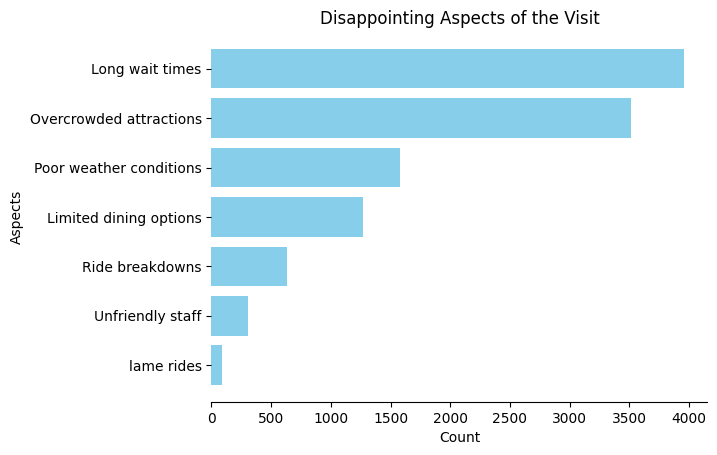

In [34]:
plt.title("Preferred Attractions")
analyze_select_all(survey_data, 'what are your preferred attraction(s)? select all that apply.')

plt.title("Disappointing Aspects of the Visit")
analyze_select_all(survey_data, 'which aspect of your visit was the most disappointing? (select all that apply)')

The above analysis is extracted from our survey responses which already has predefined options. 

From the "Preferred Attractions" plot, the strong preference for Thrill Rides over Kid-friendly attractions can create significant overcrowding which leads to long wait times at popular attractions.

From the "Disappointing Aspects of the Visit" plot, the most disappointing aspects for guests are Long wait times and Overcrowded attractions.

Given these two analysis, it is important to focus on reducing long wait times and have better crowd management to improve overall guest experience.



Lastly, we analysed the open-ended responses in our 'additional comments' column

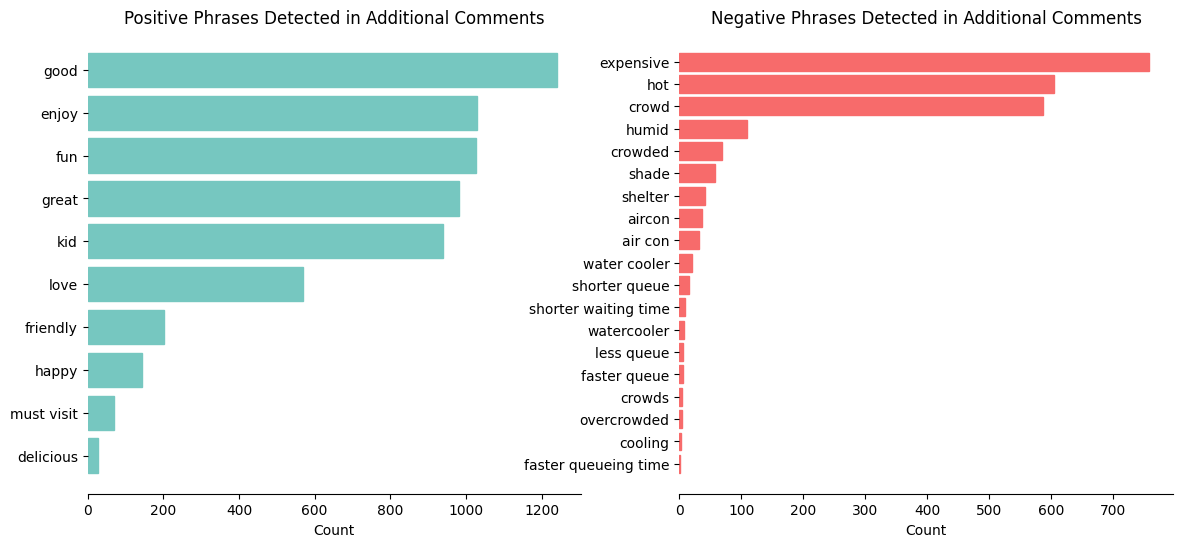

In [35]:
# First, we clean and lemmatize the responses
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
custom_stopwords = {'na', 'nil'}
stop_words.update(custom_stopwords)

def clean_and_lemmatize_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = [word for word in text.split() if word not in stop_words]
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmatized)

responses = survey_data['additional_comments'].dropna().apply(str) 
cleaned_responses = responses.apply(clean_and_lemmatize_text)

# Predefined phrases to detect
positive_phrases = ["fun", "happy", "good", "great", "friendly", "love", "kid", "must visit", "enjoy", "delicious"]
negative_phrases = ["shorter waiting time", "less queue", "shorter queue", "faster queueing time", "faster queue", "long"
                     "fan", "aircon", "air con", "water cooler", "watercooler", "shade", "hot", "cooling", "humid", "shelter",
                     "overcrowded", "over crowd", "crowd", "crowds", "crowded",
                     "expensive"]

def detect_phrases(text_series, phrases):
    detected_counts = Counter()
    
    # Iterate over each comment in the text series
    for text in text_series.dropna():
        normalized_text = text.lower()
        # Check for each phrase in the normalized text
        for phrase in phrases:
            if phrase in normalized_text:
                detected_counts[phrase] += 1  
                
    return detected_counts


# Count detected phrases in additional comments
positive_counts = detect_phrases(cleaned_responses, positive_phrases)
negative_counts = detect_phrases(cleaned_responses, negative_phrases)

positive_counts_sorted = dict(sorted(positive_counts.items(), key=lambda item: item[1], reverse=True))
negative_counts_sorted = dict(sorted(negative_counts.items(), key=lambda item: item[1], reverse=True))

# Prepare data for plotting
positive_phrases, positive_counts_values = zip(*positive_counts_sorted.items())
negative_phrases, negative_counts_values = zip(*negative_counts_sorted.items())

# Create two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Positive phrases bar chart
axs[0].barh(positive_phrases, positive_counts_values, color="#76c7c0", edgecolor="#76c7c0")
axs[0].set_title("Positive Phrases Detected in Additional Comments")
axs[0].set_xlabel("Count")
axs[0].invert_yaxis()  

# Negative phrases bar chart
axs[1].barh(negative_phrases, negative_counts_values, color="#f76b6b", edgecolor="#f76b6b")
axs[1].set_title("Negative Phrases Detected in Additional Comments")
axs[1].set_xlabel("Count")
axs[1].invert_yaxis()  

# Customize the plots
for ax in axs:
    ax.grid(False)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.spines["left"].set_visible(False)   

# Adjust layout
plt.show()

As our data is based-off open ended comments, we had to predefine certain phrases to detect which became variables for our plot above. As such, not all positive and negative comments are captured here as there might be more expressions used that may correlate to the variables above. 

Positive comments were centered around enjoyment, fun, and friendliness of the attractions.

Notable negative feedback centers on high costs, excessive heat, and overcrowding. This emphasises the need for more affordable dining/shopping options, more shades and cooling areas as well as better crowd management.

# Optimisation Model to minimise Wait Times

From our above analysis, here are our findings:

1. We have deduced that wait times highly influence guest satisfaction. In particular, longer wait times and queues lead to lower overall guest satisfaction. 
2. Another factor that strongly affects guest satisfaction is the presence of crowds, which exacerbates the heat and humidity. This generally leads to an unpleasant experience, reducing guest satisfaction.

We decided to target the problem of long wait times to directly boost guest satisfaction. Furthermore, faster queues will lead to less overcrowding at popular attractions, reducing the frustration faced by many guests. 

## Attraction Data

We reuse the attractions_df from subgroup B question 1, adding columns for estimated capacity per hour and estimated distance from entrance for each attraction

For estimated capacity per hour, we assumed that:
1. Popular Thrill Rides (e.g., Battlestar Galactica, Transformers): Thrill rides that can accommodate multiple guests per cycle typically have higher capacities (e.g., 1000–2000 guests/hour), considering ride duration and loading times. Dual-track rides like Battlestar Galactica are estimated on the higher end due to simultaneous capacity.

2. Shows and Large-Scale Experiences (e.g., WaterWorld, Shrek 4-D Adventure): Shows can handle many guests at once in an auditorium setting, so capacities tend to be high (e.g., WaterWorld at 2000/hour) as seating allows rapid audience turnover between shows.

3. Small Family and Kid-Friendly Rides (e.g., Magic Potion Spin, Dino-Soarin): Smaller rides aimed at children and families generally accommodate fewer people at a time. Capacities are estimated lower (e.g., 400–900 guests/hour) due to lower throughput and slower loading.

4. Walkthrough Experiences and Meet-and-Greets (e.g., Trolls Hug Time Jubilee, Raptor Encounter): These are estimated on the lower side (e.g., 100–400 guests/hour) as they are often slower experiences, with visitors moving through at their own pace or in small groups.

For estimated distance from entrance, we considered that Universal Studios Singapore is designed around a central lagoon, with the entrance located at the southernmost point (Hollywood zone) and other zones arranged in a circular layout around it. Based on this, we estimated the distances from each zone to the entrance, and assigned distances based on the zone:

1. Attractions located in the Hollywood zone were assigned shorter distances, reflecting their close proximity to the entrance (50-150 meters).

2. Attractions in the Sci-Fi City zone were estimated to be slightly further from the entrance (250-400 meters), given their position to the east of the entrance.

3. Attractions in the Ancient Egypt and The Lost World zones were placed further away, with distances estimated at 400-700 meters based on their locations directly north of the entrance.

4. Far Far Away attractions are estimated to be around 350-600 meters from the entrance, as they are positioned on the opposite side of the lagoon.

In [36]:
# corresponding estimated capacity per hour for each attraction
estimated_capacity = [400, 600, 500, 2000, 1200, 600, 500, 200, 1100, 400, 800, 400, 1000, 2000, 100, 100, 900, 400, 800, 250, 1000, 300]

# corresponding estimated distance from entrance of the park for each attraction
estimated_distance = [50, 100, 150, 300, 350, 400, 250, 300, 500, 450, 600, 500, 400, 700, 600, 500, 350, 400, 600, 500, 600, 450]


In [37]:
# names of attractions
attraction_names = [
        '[Hollywood] Trolls Hug Time Jubilee', '[New York] Sesame Street Spaghetti Chase', 
        '[New York] Lights, Camera, Action!', '[Sci-Fi City] Battlestar Galatica: HUMAN vs CYLON',
        '[Sci-Fi City] TRANSFORMERS The Ride: The Ultimate 3D Battle', '[Sci-Fi City] Accelerator', 
        '[Sci-Fi City] TRANSFORMERS: Voices of Cybertron', '[Sci-Fi City] Sci-Fi Games', 
        '[Ancient Egypt] Revenge of the Mummy', '[Ancient Egypt] Treasure Hunters', 
        '[The Lost World] Canopy Flyer', '[The Lost World] Dino-Soarin', 
        '[The Lost World] Jurassic Park Rapid Adventure', '[The Lost World] WaterWorld', 
        '[The Lost World] Hatched! Featuring Dr. Rooney', '[The Lost World] Raptor Encounter with Blue', 
        '[Far Far Away] Enchanted Airways', '[Far Far Away] Magic Potion Spin', 
        '[Far Far Away] Puss In Boots Giant Journey', '[Far Far Away] Donkey Live', 
        '[Far Far Away] Shrek 4-D Adventure', '[Far Far Away] Happily Ever After']

# corresponding binary encoding for whether the attraction is indoor (1) or outdoor (0)
attraction_is_indoor = [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]

# corresponding label encoding for whether the attraction is kid-friendly (1) or thrill ride (2)
attraction_thrill = [1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1]

# collate into a dataframe
attractions_df = pd.DataFrame({
        "attraction_name": attraction_names,
        "is_indoor": attraction_is_indoor,
        "kid_or_thrill": attraction_thrill,
        "estimated_capacity": estimated_capacity,
        "estimated_distance": estimated_distance
})

attractions_in_survey = survey_data["which attraction(s) did you visit? (select all that apply)\n* includes meet-and-greets, theatre shows etc."]

# count the number of times each attraction appeared
attraction_count = defaultdict(int) # initialise 0
for entry in attractions_in_survey:
    for attraction in attraction_names:
        if attraction in entry:
            attraction_count[attraction] += 1

attraction_count = pd.DataFrame(list(attraction_count.items()), columns=['attraction_name', 'visit_count'])

# add to attractions_df
attractions_df = attractions_df.merge(attraction_count, on='attraction_name', how='left')
attractions_df['visit_count'] = attractions_df['visit_count'].fillna(0)

attractions_df['proportion'] = attractions_df['visit_count'] / attractions_df['visit_count'].max()
attractions_df['popularity_factor'] = attractions_df['visit_count'] / attractions_df['visit_count'].max() * 2

#attractions_df.to_csv('attractions_df.csv', index=False)

In [38]:
attractions_df.head()

,attraction_name,is_indoor,kid_or_thrill,estimated_capacity,estimated_distance,visit_count,proportion,popularity_factor
0,[Hollywood] Trolls Hug Time Jubilee,1,1,400,50,511.0,0.122571,0.245143
1,[New York] Sesame Street Spaghetti Chase,1,1,600,100,2477.0,0.594147,1.188295
2,"[New York] Lights, Camera, Action!",1,1,500,150,1634.0,0.391941,0.783881
3,[Sci-Fi City] Battlestar Galatica: HUMAN vs CYLON,0,2,2000,300,3234.0,0.775726,1.551451
4,[Sci-Fi City] TRANSFORMERS The Ride: The Ultim...,1,2,1200,350,3444.0,0.826097,1.652195


## 1. Minimising wait times by optimising ride capacities

To target finding 1, we decided to look into the ride capacities at Universal Studios Singapore, to determine if changes in ride capacity can optimise guest flow and hence decrease wait times, leading to higher overall guest satisfaction.

We implement a minimisation function to optimise ride capacity, taking into account the average yearly attendance over the past years (not including years in which attendance was affected by the COVID-19 pandemic), estimated ride capacities and the popularity factor of each attraction.

We collected data on USS attendance from Wikipedia, which listed data from 2010 to 2022. 
We then estimated the attendance for 2023 and 2024 based on the following assumptions:

1. From 2010 to 2019, attendance grew steadily, with some fluctuations. We can calculate an average growth rate over these years as a baseline.

2. Attendance in 2020 and 2021 dropped significantly due to COVID-19 restrictions, then started recovering in 2022.

3. We project that attendance in 2023 would almost return to pre-pandemic levels, as international travel and tourism continued recovering. We can assume attendance close to 4.4 million, similar to 2018-2019. In 2024, we assume a slight growth from 2023, estimating that attendance could reach approximately 4.5 million if trends continue.

In [39]:
data = {
    'Year': [
        2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 
        2020, 2021, 2022, 2023, 2024
    ],
    'Attendance': [
        2000000, 3411000, 3480000, 3650000, 3840000, 4200000, 4100000, 4220000,
        4400000, 4500000, 1098000, 1200000, 2100000, 4400000, 4500000
    ]
}

attendance_df = pd.DataFrame(data)
attendance_df.head()


,Year,Attendance
0,2010,2000000
1,2011,3411000
2,2012,3480000
3,2013,3650000
4,2014,3840000


In [40]:
# Function to optimise ride capacities
np.set_printoptions(suppress=True)

def optimize_ride_capacities(attractions_df, attendance_df):
    # Calculate average yearly guests
    filtered_attendance_df = attendance_df[~attendance_df['Year'].isin([2020, 2021, 2022])] # To account for COVID-19
    average_yearly_guests = filtered_attendance_df['Attendance'].mean()
    total_daily_guests = average_yearly_guests / 365     
    
    # Initial capacities from attractions_df
    initial_capacities = attractions_df['estimated_capacity'].values
    popularity_factors = attractions_df['popularity_factor'].values

    print("Initial Capacities:", initial_capacities)
    
    # Define the objective function: minimize the difference between actual capacity and required capacity
    def capacity_objective(capacities):
        # Calculate weighted required capacity based on popularity
        total_popularity = np.sum(popularity_factors)
        weighted_required_capacity = (total_daily_guests * popularity_factors) / total_popularity
        
        # Minimize squared differences between capacities and weighted required capacities
        return np.sum((capacities - weighted_required_capacity) ** 2)
    
    # Constraints to ensure capacities are greater than zero
    bounds = [(1, None)] * len(initial_capacities)  
    
    # Run optimization
    result = minimize(capacity_objective, initial_capacities, bounds=bounds)

    # Optimal capacities
    optimal_capacities = result.x
    
    return optimal_capacities

optimal_capacities = optimize_ride_capacities(attractions_df, attendance_df)
print("Optimal Capacities:", optimal_capacities)


Initial Capacities: [ 400  600  500 2000 1200  600  500  200 1100  400  800  400 1000 2000
  100  100  900  400  800  250 1000  300]
Optimal Capacities: [ 147.29521492  713.99265627  470.998789    932.19711361  992.72939371
  476.18727015  443.03864055  125.67654345 1201.70988455  373.85889187
  780.28991545  424.01420966  983.79367617  352.52846936    1.
  107.22861045  786.34314347  203.21551177    1.          159.11342198
  598.69307513  389.42433534]


The results of the optimisation show that:
1. Many attractions have had their capacities significantly reduced from their initial estimated values. 
- For instance, the first attraction, '[Hollywood] Trolls Hug Time Jubilee' has an optimised capacity reduced from 400 to approximately 147.30, while the sixth attraction, '[Sci-Fi City] TRANSFORMERS: Voices of Cybertron', has an optimised capacity reduced from 600 to approximately 476.19.
- This may mean that many attractions are not that popular, as indicated by the popularity factor. Since '[Hollywood] Trolls Hug Time Jubilee' is a show targeted to young children while '[Sci-Fi City] TRANSFORMERS: Voices of Cybertron' is simply a talking robot, the reduced optimal capacities aligns with the lack of popularity of these attractions.

2. Some attractions have had their capacities increased from their initial estimated values.
- For instance, the attraction '[Ancient Egypt] Revenge of the Mummy' has a higher optimised capacity of about 1201.71 compared to its intial estimated capacity of 1100, and the attraction '[New York] Sesame Street Spaghetti Chase' has a higher optimised capacity of about 713.99 compared to its initial estimated capacity of 600.
- This means that some attractions are overwhelmingly popular and requires higher ride capacities in order to minimise wait times for these attractions

3. Some attractions have values of 1, namely '[Far Far Away] Puss In Boots Giant Journey' and '[The Lost World] Hatched! Featuring Dr. Rooney'
- This is due to the popularity_factor of these attractions being 0 as there was a lack of data collected regarding these attractions in our survey. In other words, when asked to choose the attractions they previously visited in USS, survey respondents did not choose these attractions.
- Hence for these attractions, the optimisation model would not work effectively.

Since the optimisation aims to minimise the difference between the actual estimated capacities and the required capacities to accommodate the average number of guests, it seems to have redistributed the capacities while minimising wait times successfully. This means that if the above ride capacity suggestions were implemented, wait times should decrease for most attractions.

## 2. Minimising wait times by optimising attraction distances

We also wanted to analyse the layout of Universal Studios Singapore, to see if any changes to the attraction layout can optimise guest flow and hence decrease wait times, leading to higher overall guest satisfaction.

We implement a minimisation function to find the optimal distance for each attraction, with the overall USS attendance and popularity factor as constraints. 

Using the forecasted wait times from our demand forecasting model in subgroup B question 1, we find the average wait time for each attraction to use as an inital estimate, saved in forecast_df.

In [47]:
forecast_df = forecast_data.groupby('attraction_name')['forecast'].mean().reset_index()

forecast_df['forecast'] = forecast_df['forecast'].fillna(0)
forecast_df

,attraction_name,forecast
0,[Ancient Egypt] Revenge of the Mummy,38.871641
1,[Ancient Egypt] Treasure Hunters,12.093018
2,[Far Far Away] Donkey Live,5.147098
3,[Far Far Away] Enchanted Airways,25.435794
4,[Far Far Away] Happily Ever After,12.596669
5,[Far Far Away] Magic Potion Spin,6.573358
6,[Far Far Away] Puss In Boots Giant Journey,0.000000
7,[Far Far Away] Shrek 4-D Adventure,19.365788
8,[Hollywood] Trolls Hug Time Jubilee,4.764560
9,"[New York] Lights, Camera, Action!",15.235433


In [48]:
# Function to optimise estimated distances from entrance
np.set_printoptions(suppress=True)

def optimize_estimated_distances(attractions_df, attendance_df, forecast_df):
    # Calculate average yearly guests 
    filtered_attendance_df = attendance_df[~attendance_df['Year'].isin([2020, 2021, 2022])] # To account for COVID-19
    average_yearly_guests = filtered_attendance_df['Attendance'].mean()
    total_daily_guests = average_yearly_guests / 365

    # Initial distances and wait times
    initial_distances = attractions_df['estimated_distance'].values
    popularity_factors = attractions_df['popularity_factor'].values
    initial_wait_times = forecast_df['forecast'].values

    print("Initial Distances:", initial_distances)

    # Define the objective function to minimize total wait times   
    def distance_objective(distances):
        
        adjusted_wait_times = initial_wait_times * (distances / np.max(distances)) * (popularity_factors / np.sum(popularity_factors))
        total_wait_time = np.sum(adjusted_wait_times * total_daily_guests)

        # Add a penalty for large changes in distance
        distance_change_penalty = np.sum((distances - initial_distances) ** 2)  

        total_cost = total_wait_time + distance_change_penalty
        #print(f"Distances: {distances}, Total Cost: {total_cost}")
        return total_cost
    
    # Constraints: distances must be greater than a minimum positive value
    bounds = [(1, None)] * len(initial_distances)  

    # Run optimization
    result = minimize(distance_objective, initial_distances, bounds=bounds)

    # Optimal distances
    optimal_distances = result.x

    return optimal_distances

optimal_distances = optimize_estimated_distances(attractions_df, attendance_df, forecast_df)
print("Optimal Distances:", optimal_distances)


Initial Distances: [ 50 100 150 300 350 400 250 300 500 450 600 500 400 700 600 500 350 400
 600 500 600 450]
Optimal Distances: [ 46.19520073  94.2618611  148.38948492 284.24077381 341.68839544
 397.91990054 250.         298.3830602  496.19520344 446.21478727
 588.02279075 495.65947588 380.28387482 752.31829764 600.
 498.97827015 336.80943946 398.14806683 600.         496.63545117
 598.61978774 447.0490818 ]


The results of the optimisation show that:

1. After optimisation, the optimal distances of most attractions from the entrance have decreased from their intial estimated distances.
- For example, the optimal distance from the entrance for the attraction '[Hollywood] Trolls Hug Time Jubilee' is about 46.20m, lower than the original estimated distance of 50m. 
- This suggests that reducing the distance of most attractions from the entrance may help to balance guest flow, decreasing wait times.

2. Some attractions have increased optimal distances from the entrance.
- For instance, the optimal distance from the entrance of the attraction '[The Lost World] WaterWorld' has increased from the original estimated distance of 700m to about 752.32m.
- This means that maintaining a larger distance for this attraction contributes positively to reducing overall wait times. 

3. Some attractions did not have any change in optimal distance compared to the initial estimated distance.
- The attractions '[Sci-Fi City] TRANSFORMERS: Voices of Cybertron', '[Far Far Away] Puss In Boots Giant Journey' had the same optimal distances as the original estimated distance. 
- This suggests that their current distances were already optimal relative to the other attractions. 

Overall, the optimisation successfully reduced distances for most attractions, while allowing for flexibility in increasing distances where it might lead to better operational efficiency. This means that if the above attractions were constructed according to the suggested optimal distances, wait times should decrease for most attractions.

# Simulating the impact of proposed changes

In this section, we aim to simulate the impact of proposed changes on wait times, guest satisfaction, and revenue. We understand that it may be difficult to increase the ride capacities of certain rides, and it may be impossible to completely change the attraction layouts, hence the results of this simulation is mainly hypothetical, assuming an ideal scenario. 

In [50]:
forecast_data.head()

,Unnamed: 0,attraction_name,date,forecast
0,0,[Hollywood] Trolls Hug Time Jubilee,2024-10-22,4.328193
1,1,[Hollywood] Trolls Hug Time Jubilee,2024-10-23,4.485268
2,2,[Hollywood] Trolls Hug Time Jubilee,2024-10-24,5.106852
3,3,[Hollywood] Trolls Hug Time Jubilee,2024-10-25,4.978704
4,4,[Hollywood] Trolls Hug Time Jubilee,2024-10-26,6.246666


In [83]:
# Collate optimised ride capacities and optimised distances from entrance for each attraction for simulation
simulation_df = pd.DataFrame({
        "attraction_name": attraction_names,
        "estimated_capacity": estimated_capacity,
        "estimated_distance": estimated_distance, 
        "optimised_capacity": optimal_capacities,
        "optimised_distances": optimal_distances, 
        "popularity_factor": attractions_df['popularity_factor']
})

# Replace optimised_capacity with estimated_capacity if optimised_capacity == 1.0 (due to lack of data)
simulation_df['optimised_capacity'] = np.where(
    simulation_df['optimised_capacity'] == 1.0, 
    simulation_df['estimated_capacity'], 
    simulation_df['optimised_capacity']
)

simulation_df.head()

# simulation_df.to_csv("simulation_df.csv")
# attendance_df.to_csv("attendance_df.csv")

In [120]:
def simulate_wait_times(simulation_df, attendance_df, forecast_df, baseline_guests=100, time_interval=60):

    simulation_forecast = pd.merge(simulation_df, forecast_df, on='attraction_name')

    # Operating hours in minutes (e.g., 10 am - 9 pm = 660 minutes) 
    operating_hours = 660
    num_intervals = operating_hours // time_interval

    # Calculate average yearly guests 
    filtered_attendance_df = attendance_df[~attendance_df['Year'].isin([2020, 2021, 2022])]  # To account for COVID-19
    average_yearly_guests = filtered_attendance_df['Attendance'].mean()
    total_forecasted_guests = average_yearly_guests / 365

    simulation_results = []

    # Calculate the sum of estimated capacities for normalization
    estimated_capacity = simulation_forecast['estimated_capacity']
    total_capacity = sum(estimated_capacity)

    # Calculate base guest distribution according to estimated capacities
    base_distribution = [(cap / total_capacity) * total_forecasted_guests for cap in estimated_capacity]

    for index, row in simulation_forecast.iterrows():
        # Extract attraction-specific data
        attraction_name = row['attraction_name']
        optimised_distance = row['optimised_distances']
        popularity_factor = row['popularity_factor']
        date = row['date']
        forecast = row['forecast']

        # Get the corresponding base guests for the attraction
        base_guests = base_distribution[index]

        # Calculate distance factor
        max_distance = simulation_forecast['optimised_distances'].max()
        distance_factor = max(0.1, (max_distance - optimised_distance) / max_distance) if max_distance > 0 else 1

        # Adjust guest distribution with higher popularity influence
        weight_distance = 0.1  
        weight_popularity = 1
        weight_forecast = 0.25

        # Calculate guests per interval based on capacity and factors
        guests_per_interval = (
            (base_guests * 0.15) *
            (distance_factor * weight_distance + popularity_factor * weight_popularity + forecast * weight_forecast) + baseline_guests
        )

        # Debugging: Print the calculated values
        # print(f"Attraction: {attraction_name}")
        # print(f"  Base Guests: {base_guests}, Distance Factor: {distance_factor}, Popularity Weight: {popularity_factor}")
        # print(f"  Estimated Capacity: {estimated_capacity[index]}, Guests per Interval: {guests_per_interval}")

        # Initialize wait time tracking
        queue = 0
        wait_times = []

        # Simulate each time interval
        for t in range(num_intervals):
            arrivals = guests_per_interval
            processed = arrivals + queue  # No cap on processing
            queue = max(processed - estimated_capacity[index], 0)  # Update queue if exceeds capacity
            wait_time = (queue / estimated_capacity[index]) * time_interval if estimated_capacity[index] > 0 else 0
            wait_times.append(wait_time)

        # Store results for this attraction
        simulation_results.append({
            'attraction_name': attraction_name,
            'date': date,
            'average_wait_time': np.mean(wait_times),
            'max_wait_time': np.max(wait_times),
            'total_wait_time': np.sum(wait_times)
        })

    simulation_result = pd.DataFrame(simulation_results)

    # Merge the two DataFrames on 'attraction_name'
    merged_results = pd.merge(simulation_result[['attraction_name', 'date', 'average_wait_time']], simulation_forecast[['attraction_name', 'forecast']], on='attraction_name')

    # Calculate the difference between average_wait_time and forecast
    merged_results['wait_time_difference'] = merged_results['average_wait_time'] - merged_results['forecast']

    # Total decrease in wait time
    wait_time_decrease = merged_results['wait_time_difference'].sum()
    print(f'For {date}, Total change in wait time: {wait_time_decrease} minutes')

    return merged_results

In [123]:
def simulate_2_weeks(simulation_df, attendance_df, forecast_data):
    unique_dates = forecast_data['date'].unique()

    # Initialize final_results as an empty DataFrame
    final_results = pd.DataFrame()

    for date in unique_dates:
        daily_forecast = forecast_data.loc[forecast_data['date'] == date, ['attraction_name', 'forecast', 'date']]
        simulation_results = simulate_wait_times(simulation_df, attendance_df, daily_forecast)

        # Concatenate the simulation_results DataFrame with final_results
        final_results = pd.concat([final_results, simulation_results], ignore_index=True)

    return final_results


final_results = simulate_2_weeks(simulation_df, attendance_df, forecast_data)
final_results.head(20)

# final_results.to_csv("final_results.csv")


For 2024-10-22, Total change in wait time: -191.35389189868178 minutes
For 2024-10-23, Total change in wait time: -170.29304013790156 minutes
For 2024-10-24, Total change in wait time: -70.02645759528826 minutes
For 2024-10-25, Total change in wait time: -94.71600585279883 minutes
For 2024-10-26, Total change in wait time: 256.5053533518031 minutes
For 2024-10-27, Total change in wait time: -204.11598962488765 minutes
For 2024-10-28, Total change in wait time: -49.84098907869708 minutes
For 2024-10-29, Total change in wait time: -173.13807684239 minutes
For 2024-10-30, Total change in wait time: -178.29775547057292 minutes
For 2024-10-31, Total change in wait time: -205.65526653115305 minutes
For 2024-11-01, Total change in wait time: -127.29498695739817 minutes
For 2024-11-02, Total change in wait time: 179.3874207060126 minutes
For 2024-11-03, Total change in wait time: -205.58652401730578 minutes
For 2024-11-04, Total change in wait time: -87.74807610635136 minutes


Analysis of simulation results:

In summary, our simulation indicates that optimising ride capacities and distances has resulted in an impressive reduction in overall wait times of most days as compared to the projections from our demand forecasting model. This significant decrease demonstrates the effectiveness of our optimization strategies in enhancing guest experiences by minimizing wait times, which is crucial for boosting overall satisfaction.

Furthermore, improved guest satisfaction often translates into increased revenue, as satisfied visitors are more likely to recommend the venue to others and return for future visits. By prioritizing guest experience through strategic enhancements, we can create a cycle of positive feedback that not only elevates guest satisfaction but also drives long-term financial success for the venue. 